In [1]:
# Import necessary libraries for data handling, model utilization, and visualization
import numpy as np
import pandas as pd
import yfinance as yf  # For collecting financial data
import matplotlib.pyplot as plt
from typing import List, Dict, Optional, Tuple
from scipy.optimize import minimize 
from datetime import datetime, timedelta
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from collections import deque
# Import the custom Model class
from Model import Model

# Set the random seed for reproducibility across numpy and tensorflow
np.random.seed(123)

plt.style.use('seaborn-darkgrid')

# Define the tickers and date range with consideration of trading days
TICKERS = ['AGG','DBC','VTI','^VIX']

# Approximate number of trading days per year (useful for annualizing returns)
TRADING_DAYS_PER_YEAR = 252

# Confirm setup
print("Setup complete: libraries imported, random seed set, and tickers defined.")


Setup complete: libraries imported, random seed set, and tickers defined.


C:\Users\wiztu\AppData\Local\Temp\ipykernel_15084\1997288386.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [2]:
# Data Collection Step
# Objective: Fetch historical adjusted close prices for defined tickers and date range

# Download data using yfinance for the specified tickers and date range
def get_data(tickers, start_date, end_date):
    """
    Retrieves historical adjusted close prices for the given tickers and date range.
    
    Parameters:
    - tickers: List of stock ticker symbols
    - start_date: Start date for historical data
    - end_date: End date for historical data
    
    Returns:
    - DataFrame of adjusted close prices, with each column representing a ticker
    """
    # Fetch data from yfinance
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    
    # Drop rows with missing values, if any, to ensure data continuity
    data.dropna(inplace=True)
    
    return data

# Fetch the data and display a quick preview
data = get_data(TICKERS, '2000-01-01', '2021-01-04')
print("Data fetched successfully. Sample data:")
print(data.head())

# Confirm data spans the expected range and has the expected number of columns
print(f"Data covers {len(data)} trading days with {len(data.columns)} assets.")


[*********************100%%**********************]  4 of 4 completed

Data fetched successfully. Sample data:
Ticker            AGG        DBC        VTI   ^VIX
Date                                              
2006-02-06  56.300129  20.889494  44.654274  13.04
2006-02-07  56.260769  20.285254  44.219494  13.59
2006-02-08  56.232742  20.198935  44.537613  12.83
2006-02-09  56.266415  20.388840  44.452785  13.12
2006-02-10  56.148434  20.017662  44.544689  12.87
Data covers 3753 trading days with 4 assets.


In [3]:
def preprocess_data(data, rolling_window=50):
    """
    Prepares data by calculating 50-day rolling averages and returns.

    Parameters:
    - data: DataFrame of historical adjusted close prices for assets
    - rolling_window: Window size for the rolling average

    Returns:
    - normalized_data: Smoothed prices, normalized to start at 1 for each asset
    - returns: Smoothed returns using a rolling mean of percentage changes
    """
    # Calculate rolling mean for prices and returns to smooth the data
    smoothed_prices = (data.rolling(window=rolling_window).mean()).dropna()
    smoothed_returns = (data.pct_change().rolling(window=rolling_window).mean()).dropna()
    # Normalize prices to start each asset's time series at 1
    normalized_data = smoothed_prices / smoothed_prices.iloc[0]
    
    return normalized_data, smoothed_returns


# Run preprocessing and display sample data
normalized_data, smoothed_returns = preprocess_data(data)
print("Data preprocessing complete. Sample normalized data:")
print(normalized_data.head())
print("\nSample daily returns:")
print(smoothed_returns.head())


Data preprocessing complete. Sample normalized data:
Ticker           AGG       DBC       VTI      ^VIX
Date                                              
2006-04-18  1.000000  1.000000  1.000000  1.000000
2006-04-19  0.999786  1.001443  1.000798  0.997130
2006-04-20  0.999555  1.003226  1.001815  0.993875
2006-04-21  0.999332  1.005552  1.002683  0.991806
2006-04-24  0.999172  1.007249  1.003528  0.989520

Sample daily returns:
Ticker           AGG       DBC       VTI      ^VIX
Date                                              
2006-04-19 -0.000212  0.001441  0.000813 -0.001952
2006-04-20 -0.000229  0.001788  0.001035 -0.002230
2006-04-21 -0.000221  0.002295  0.000882 -0.001198
2006-04-24 -0.000157  0.001709  0.000862 -0.001374
2006-04-25 -0.000182  0.002136  0.000757 -0.000993


In [4]:
class Portfolio:
    def __init__(self, initial_cash: float, assets: pd.DataFrame):
        """
        Initializes the Portfolio object.

        Parameters:
        - initial_cash: The starting value of the portfolio in cash.
        - assets: DataFrame of asset prices (historical data).
        """
        self.initial_cash = initial_cash
        self.current_value = initial_cash
        self.assets = assets  # Historical price data for the assets
        self.weights = np.zeros(len(assets.columns))  # Initialize weights as zero
        self.portfolio_history = []  # To track portfolio value over time
        self.rebalancing_dates = []  # To store rebalancing dates

    def rebalance(self, new_weights: np.array, target_volatility = None):
        """
        Rebalances the portfolio according to new weights.

        Parameters:
        - new_weights: Numpy array of asset allocations.
        """
        if len(new_weights) != len(self.assets.columns):
            raise ValueError("Number of weights must match the number of assets.")
        self.weights = new_weights
        if target_volatility is not None:
            self.apply_volatility_scaling(target_volatility=target_volatility,rolling_window = 50)

    def calculate_initial_shares(self, initial_cash, initial_prices):
        """
        Calculates the number of shares for each asset at the start of the testing period based on
        initial cash and allocation weights.

        Parameters:
        - initial_cash: The starting cash value of the portfolio.

        Returns:
        - shares: Dictionary with tickers as keys and the initial number of shares as values.
        """
        # Calculate the dollar amount allocated to each asset
        dollar_allocation = initial_cash * self.weights

        # Calculate the number of shares for each asset
        shares = (dollar_allocation // initial_prices).astype(int)  # Floor division to get whole shares

        # Return as a dictionary for easy readability
        return dict(zip(self.assets.columns, shares))
    
    def calculate_daily_returns(self):
        """
        Applies the current weights to asset returns and updates portfolio value over time.
        """
        # Calculate daily returns for each asset
        daily_returns = self.assets.pct_change().dropna()
        
        # Calculate portfolio returns by applying weights
        portfolio_returns = np.dot(daily_returns, self.weights)

        # Track the portfolio's value over time by compounding the returns
        for daily_ret in portfolio_returns:
            self.current_value *= (1 + daily_ret)
            self.portfolio_history.append(self.current_value)

    def update_portfolio_value(self, date):
        """
        Updates the portfolio value for a single date.
        """
        # Get the index of the date
        date_index = self.assets.index.get_loc(date)
        if date_index == 0:
            # First day, no previous day to compute return
            self.portfolio_history.append(self.current_value)
            return
        # Get the asset returns for that day
        previous_date = self.assets.index[date_index - 1]
        daily_return = self.assets.loc[date] / self.assets.loc[previous_date] - 1
        # Calculate portfolio return
        portfolio_return = np.dot(daily_return.values, self.weights)
        # Update portfolio value
        self.current_value *= (1 + portfolio_return)
        # Append to history
        self.portfolio_history.append(self.current_value)


    def track_portfolio_performance(self):
        """
        Tracks and prints the portfolio performance over time.
        """
        for date, value in zip(self.assets.index[1:], self.portfolio_history):
            print(f"Date: {date}, Portfolio Value: {value}")
    
    def reset(self):
        self.current_cash = self.initial_cash
        self.assets = self.initial_assets.copy()
        self.weights = np.zeros(len(self.assets.columns))  # Reset to no investments
        self.portfolio_history = []
        self.rebalancing_dates = []
        return self.assets.iloc[0].values

    def get_portfolio_value(self):
        """
        Returns the current value of the portfolio.
        """
        return self.current_value
    
    def plot_portfolio_value(self):
        """
        Plots the portfolio value over time.
        """
        plt.figure(figsize=(10, 6))
        plt.plot(self.assets.index[1:], self.portfolio_history, label="Portfolio Value")
        plt.title("Portfolio Value Over Time")
        plt.xlabel("Date")
        plt.ylabel("Portfolio Value")
        plt.legend()
        plt.show()

    def apply_volatility_scaling(self, target_volatility=0.1, rolling_window=50):
        """
        Scales portfolio allocations based on the ratio of target volatility to current asset volatilities.
        
        Parameters:
        - target_volatility: The target annualized volatility for the portfolio (e.g., 0.1 for 10%).
        - rolling_window: The window size (in days) for calculating each asset's rolling volatility.
        
        Returns:
        - Scaled weights to achieve the target volatility for each asset.
        """
        # Calculate daily returns of the portfolio assets
        daily_returns = self.assets.pct_change().dropna()
        
        # Calculate rolling volatility (annualized) for each asset over the rolling window
        asset_volatilities = daily_returns.rolling(window=rolling_window).std().iloc[-1] * np.sqrt(252)
        asset_volatilities = asset_volatilities.dropna()
        
        # Compute scaling factor for each asset to achieve the target volatility
        scaling_factors = target_volatility / asset_volatilities

        # Scale weights by the scaling factors
        self.weights = self.weights * scaling_factors

        # Normalize weights to ensure they sum to 1
        self.weights = self.weights / np.sum(self.weights)

        # Debugging: Print intermediate values to verify calculations
        print(f"Asset Volatilities: {asset_volatilities}")
        print(f"Scaling Factors: {scaling_factors}")
        print(f"Scaled and Normalized Weights: {self.weights}")
        
        return self.weights  # Return the scaled weights


In [5]:
def train_and_rebalance_portfolio(portfolio: Portfolio, model: Model):
    """
    Trains the LSTM model once over the full dataset and returns a single set of allocation weights.

    Parameters:
    - portfolio: An instance of the Portfolio class.
    - model: An instance of the Model class for training.
    
    Returns:
    - allocations: Final optimized weights for each asset in the portfolio.
    """
    # Use the entire dataset for training
    train_data = portfolio.assets

    # Get allocations from the model
    allocations = model.get_allocations(train_data)

    # Rebalance the portfolio with the optimized weights (if needed for tracking)
    portfolio.rebalance(allocations)

    # Return the final allocation weights
    return allocations


In [6]:
def calculate_metrics(portfolio_values):
    """
    Calculates performance metrics for the portfolio.

    Parameters:
    - portfolio_values: List of daily portfolio values over the testing period.

    Returns:
    - metrics: Dictionary containing Sharpe Ratio, Sortino Ratio, and Max Drawdown.
    """
    # Convert portfolio values to daily returns
    portfolio_returns = np.diff(portfolio_values) / portfolio_values[:-1]
    
    # Calculate Sharpe Ratio
    mean_return = np.mean(portfolio_returns)
    std_dev = np.std(portfolio_returns)
    sharpe_ratio = mean_return / std_dev * np.sqrt(TRADING_DAYS_PER_YEAR)
    
    # Calculate Sortino Ratio
    downside_returns = portfolio_returns[portfolio_returns < 0]
    downside_std_dev = np.std(downside_returns)
    sortino_ratio = mean_return / downside_std_dev * np.sqrt(TRADING_DAYS_PER_YEAR)
    
    # Calculate Maximum Drawdown
    cumulative_returns = np.maximum.accumulate(portfolio_values) - portfolio_values
    max_drawdown = np.max(cumulative_returns / np.maximum.accumulate(portfolio_values))
    
    return {
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Max Drawdown": max_drawdown
    }

In [7]:
def equal_weighted_strategy(returns):
    """
    Creates an equal-weighted portfolio.

    Parameters:
    - returns: DataFrame of daily returns for each asset.

    Returns:
    - equal_weights: Numpy array of equal weights for each asset.
    """
    num_assets = returns.shape[1]
    equal_weights = np.ones(num_assets) / num_assets
    return equal_weights

def mean_variance_optimized_strategy(returns):
    """
    Creates a mean-variance optimized portfolio by maximizing the Sharpe Ratio.

    Parameters:
    - returns: DataFrame of daily returns for each asset.

    Returns:
    - optimized_weights: Numpy array of optimized weights for each asset.
    """
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    
    def neg_sharpe(weights):
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -portfolio_return / portfolio_std

    # Constraints: Weights must sum to 1, and each weight must be between 0 and 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(returns.shape[1]))

    result = minimize(neg_sharpe, np.ones(returns.shape[1]) / returns.shape[1], bounds=bounds, constraints=constraints)
    optimized_weights = result.x
    
    return optimized_weights

def maximum_diversification(returns):
    """
    Perform maximum diversification optimization based on the given returns.

    Parameters:
    - returns: DataFrame of daily returns for each asset.

    Returns:
    - optimal_weights: Array of portfolio weights that maximize diversification.
    """
    # Calculate asset volatilities (standard deviation of each asset’s returns)
    asset_volatilities = returns.std()

    # Calculate the covariance matrix of returns
    cov_matrix = returns.cov()

    # Define the diversification ratio to be maximized
    def neg_diversification_ratio(weights):
        # Calculate the weighted average asset volatility
        weighted_volatility = np.dot(weights, asset_volatilities)
        
        # Calculate the portfolio volatility as the weighted covariance matrix
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        
        # Diversification ratio (we negate this because we want to maximize it)
        diversification_ratio = weighted_volatility / portfolio_volatility
        return -diversification_ratio  # Negate to turn this into a minimization problem

    # Constraints: weights sum to 1, and each weight between 0 and 1 (long-only portfolio)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(len(asset_volatilities)))

    # Initial guess (equal allocation)
    init_guess = np.ones(len(asset_volatilities)) / len(asset_volatilities)

    # Optimize to find weights that maximize diversification ratio
    result = minimize(neg_diversification_ratio, init_guess, bounds=bounds, constraints=constraints)
    optimal_weights = result.x
    
    return optimal_weights


In [ ]:
def generalized_rolling_validation(data, allocation_strategy, train_years=2, test_months=12, initial_cash=100000):
    results = []
    final_values = []

    # Use the raw data's indices for consistent date ranges
    dates = data.index
    total_periods = len(dates)
    period_length = test_months * 21  # Approximate trading days in test_months
    start_idx = 0

    while True:
        train_end_idx = start_idx + train_years * 252  # Approximate trading days in train_years
        test_start_idx = train_end_idx + 1
        test_end_idx = test_start_idx + period_length

        # Break if we don't have enough data left
        if test_end_idx >= total_periods:
            break

        # Define date ranges using indices
        train_data = data.iloc[start_idx:train_end_idx]
        test_data = data.iloc[test_start_idx:test_end_idx]

        # Preprocess data for non-LSTM strategies
        if allocation_strategy != train_and_rebalance_portfolio:
            _, train_returns = preprocess_data(train_data)
            _, test_returns = preprocess_data(test_data)
            final_allocations = allocation_strategy(train_returns)
        else:
            # For LSTM, use raw train_data
            model = Model()
            training_portfolio = Portfolio(initial_cash=initial_cash, assets=train_data)
            final_allocations = allocation_strategy(training_portfolio, model=model)

        # Initialize testing portfolio with raw test_data
        testing_portfolio = Portfolio(initial_cash=initial_cash, assets=test_data)
        testing_portfolio.rebalance(final_allocations)
        testing_portfolio.calculate_daily_returns()
        final_values.append(testing_portfolio.get_portfolio_value())

        # Calculate performance metrics
        metrics = calculate_metrics(testing_portfolio.portfolio_history)

        # Store results
        results.append({
            'train_period': (dates[start_idx], dates[train_end_idx]),
            'test_period': (dates[test_start_idx], dates[test_end_idx]),
            'metrics': metrics
        })

        # Plot the portfolio value over time for this roll
        testing_portfolio.plot_portfolio_value()

        # Move to the next period
        start_idx += period_length

    return results, final_values


[*********************100%%**********************]  4 of 4 completed
c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: -0.1066
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1435
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.2347
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.1894
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.2321
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: -0.1617
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.2607
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.1729
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1979
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.1862
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.2495
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1944
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: -0.2114
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.2325
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.2296
Epoc

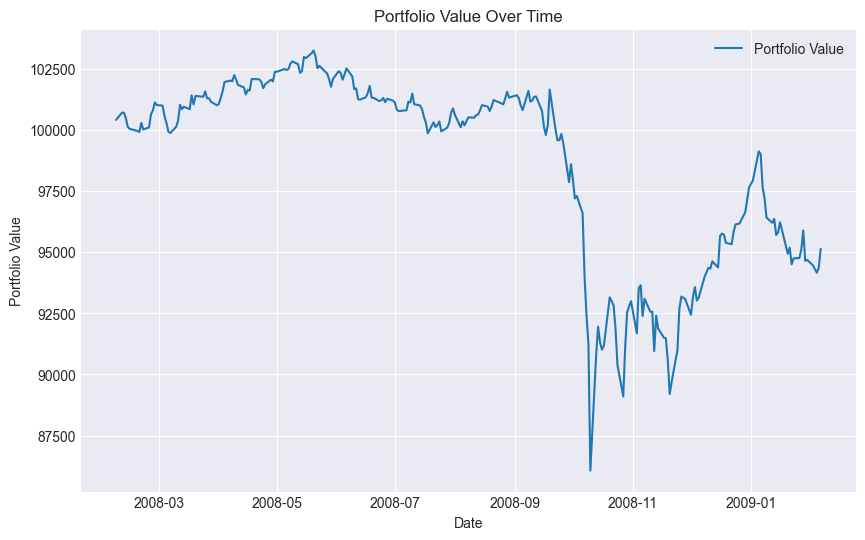

Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: -0.0993
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: -0.1076
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.1335
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.0919
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.0947
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.1296
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.0931
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.1375
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1232
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1270
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: -0.1304
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1175
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: -0.0758
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.1402
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1374
Epoch 16/100
8/8

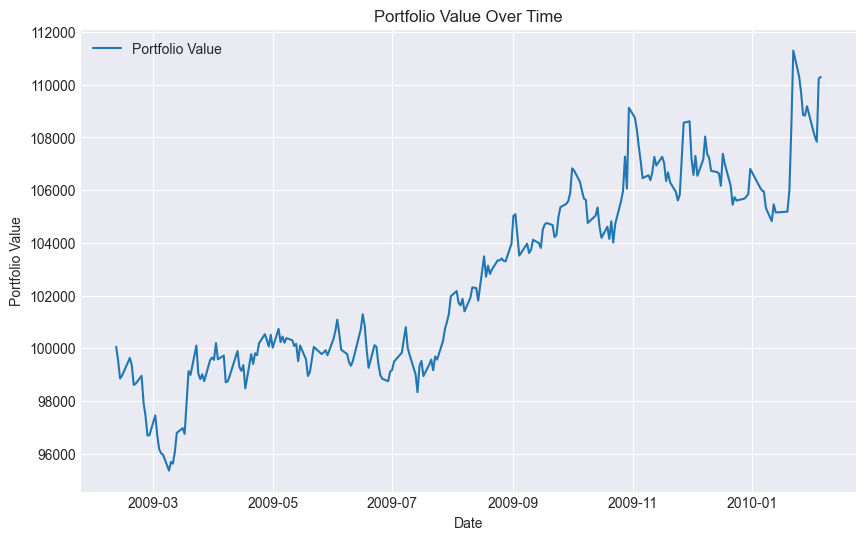

Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0408
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.0686
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.0588
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.1016
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.0508
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1200
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1141
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.1331
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1067
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.0961
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: -0.0489
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.1087
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: -0.1281
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.1173
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: -0.1372
Epoch 16/100
8/8 

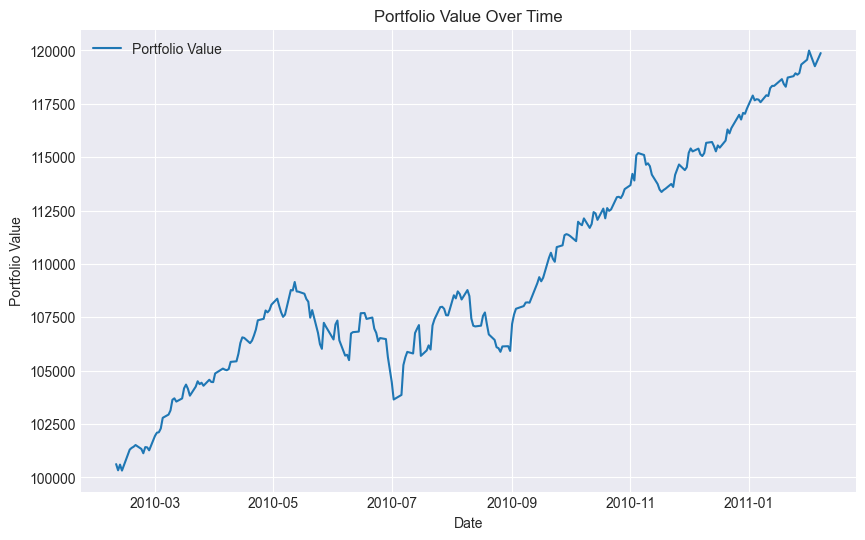

Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: -0.0259
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.0809
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.1423
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.1452
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.2159
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.1662
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.1535
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1546
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1836
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: -0.1683
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.1795
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.2433
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: -0.1538
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.1960
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: -0.1811
Epoch 16/100
8/8

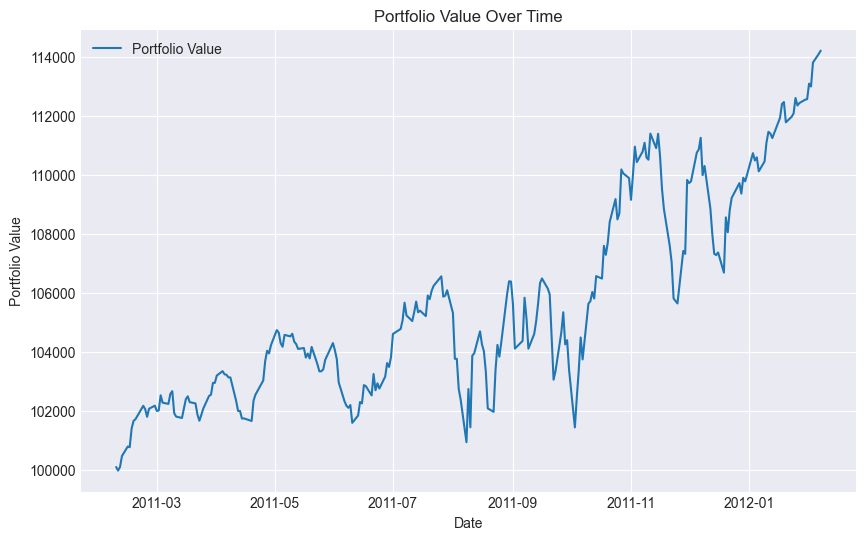

Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: -0.0559
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.0724
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1582
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1067
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.1492
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1082
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.0524
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1860
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1453
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1575
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.1521
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.1805
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: -0.1772
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.1549
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.1591
Epoch 16/100
8/8

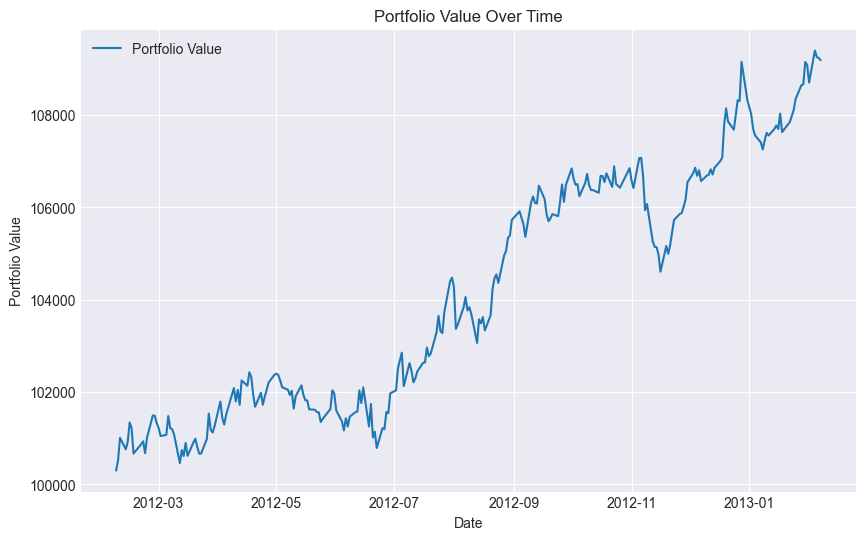

Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: -0.0182
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.0986
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.0867
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.1200
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: -0.1355
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.1034
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.1750
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.1341
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.1685
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.0979
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.1165
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.1007
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.1175
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: -0.1598
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.1519
Epoch 16/100
8/8

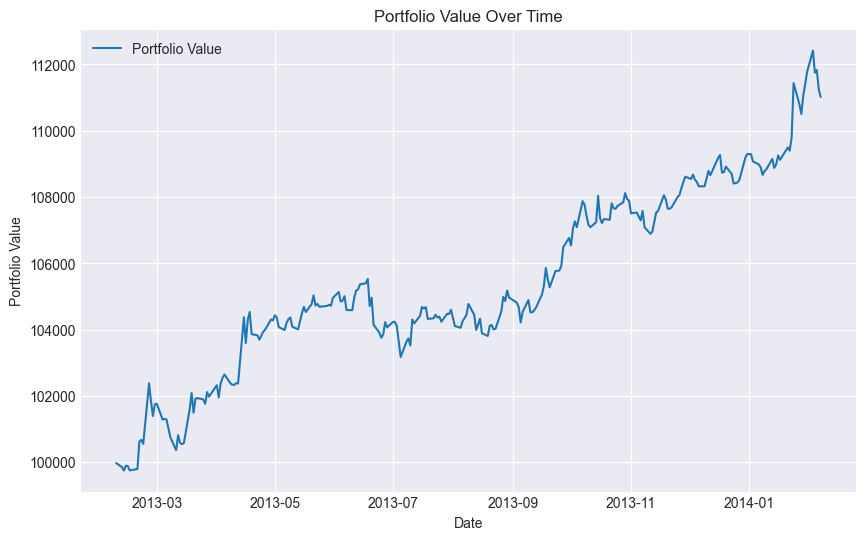

Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: -0.0840
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.2168
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.1668
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.1932
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.1808
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: -0.2305
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.1652
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.2118
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.2932
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: -0.1885
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.2127
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.2727
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.1450
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.2424
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.2347
Epoch 16/100
8/8

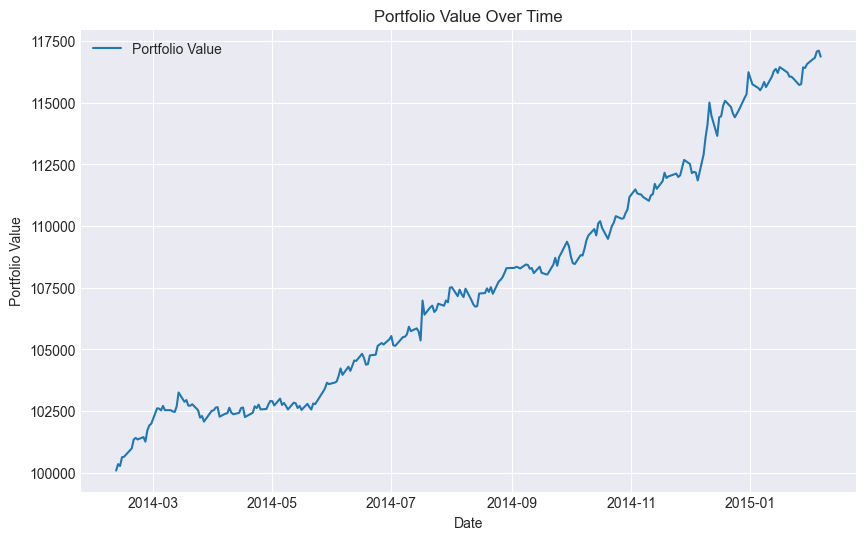

Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: -0.1097
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.1413
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.1145
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.1574
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.1988
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.2133
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: -0.2557
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.2315
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.3427
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: -0.2441
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.2053
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.2755
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.2944
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1992
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.2927
Epoch 16/100
8/8

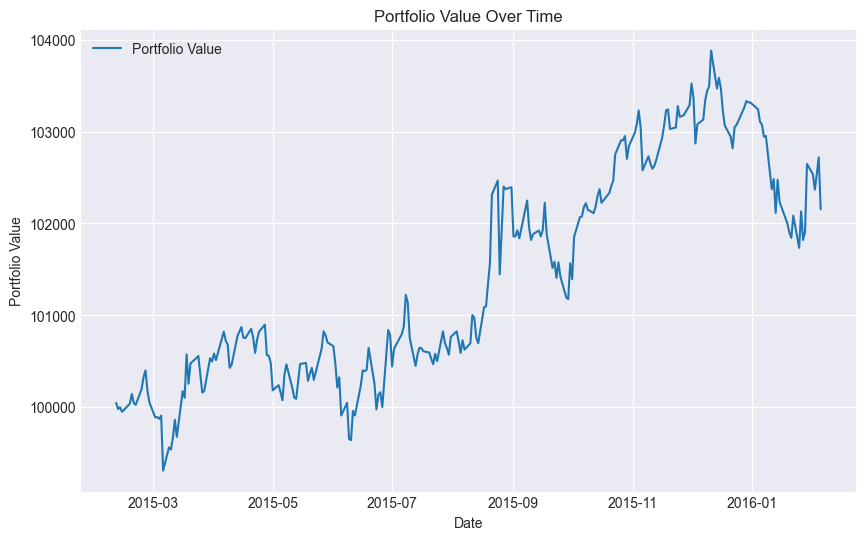

Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: -0.0572
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0423
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: -0.0639
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.0674
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.0917
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.1173
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.0828
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1207
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.1077
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1527
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1668
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.1697
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.0590
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: -0.1792
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.1354
Epoch 16/100
8/8 

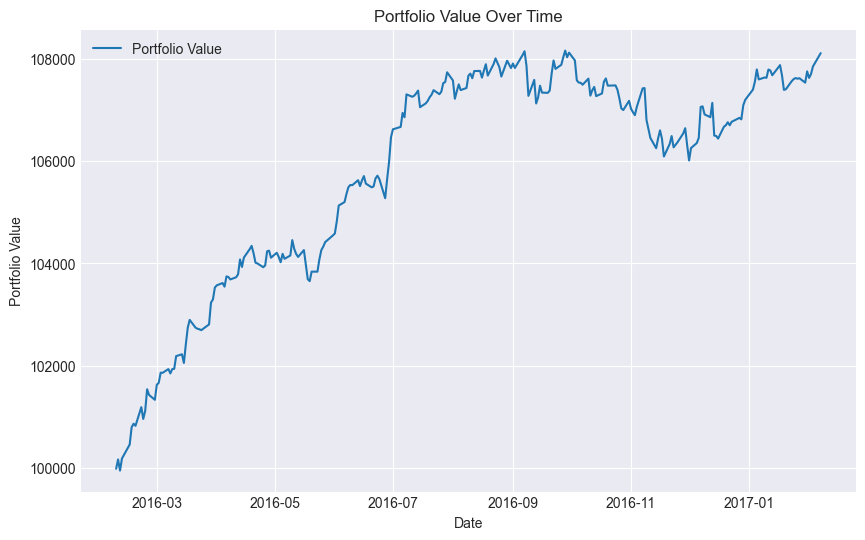

Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0172
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.0425
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: -0.1002
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: -0.1011
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.1254
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.1217
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.0980
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.1431
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.1545
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.1436
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1140
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.1149
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.1477
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.1874
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.1350
Epoch 16/100
8/8 

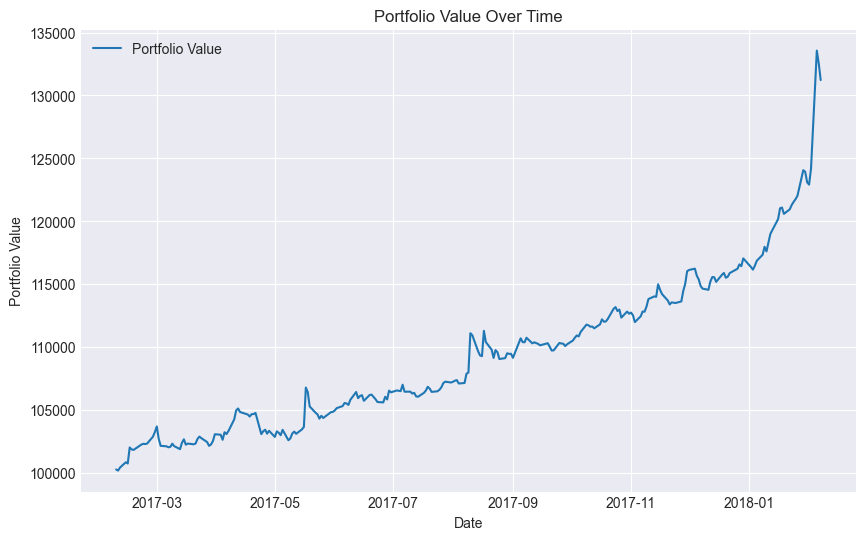

Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: -0.0602
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: -0.1090
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: -0.0721
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.1259
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.1176
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1787
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.1896
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.2330
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.2147
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.2302
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.2310
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.2454
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.2867
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.2925
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.2844
Epoch 16/100
8/8

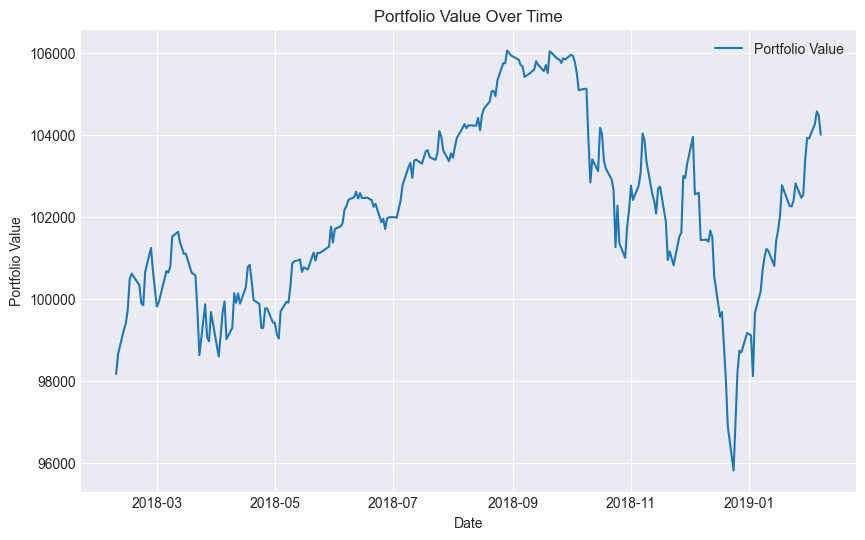

Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: -0.0240
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: -0.0290
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: -0.1141
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: -0.1035
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.1176
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.1230
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.1124
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.1097
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.0769
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: -0.1813
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: -0.1643
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: -0.1426
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.1674
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1185
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: -0.1955
Epoch 16/100
8/8

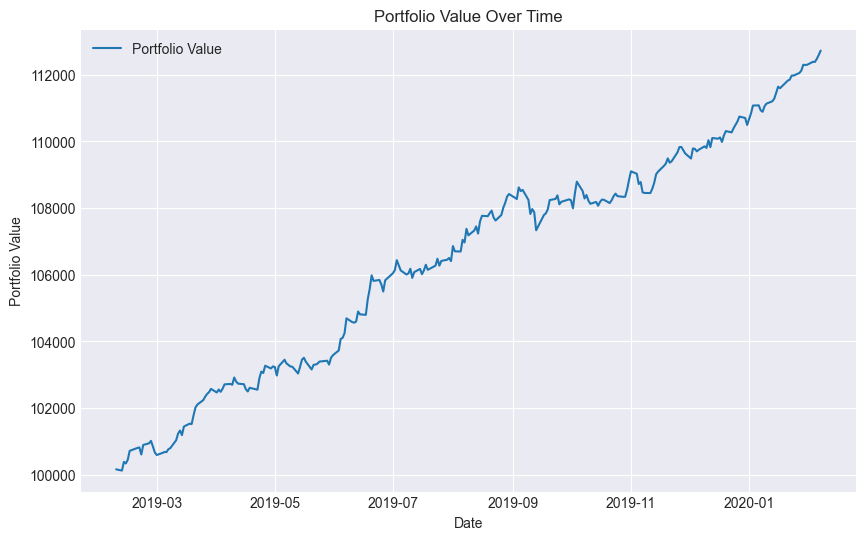

LSTM Results: [{'train_period': (Timestamp('2006-02-06 00:00:00'), Timestamp('2008-02-06 00:00:00')), 'test_period': (Timestamp('2008-02-07 00:00:00'), Timestamp('2009-02-07 00:00:00')), 'metrics': {'Sharpe Ratio': -0.3701576002820023, 'Sortino Ratio': -0.4393383353348234, 'Max Drawdown': 0.16622566481826676}}, {'train_period': (Timestamp('2007-02-06 00:00:00'), Timestamp('2009-02-06 00:00:00')), 'test_period': (Timestamp('2009-02-07 00:00:00'), Timestamp('2010-02-07 00:00:00')), 'metrics': {'Sharpe Ratio': 1.0345154722889425, 'Sortino Ratio': 2.2896908579138135, 'Max Drawdown': 0.046984142422474784}}, {'train_period': (Timestamp('2008-02-06 00:00:00'), Timestamp('2010-02-06 00:00:00')), 'test_period': (Timestamp('2010-02-07 00:00:00'), Timestamp('2011-02-07 00:00:00')), 'metrics': {'Sharpe Ratio': 2.967320087530358, 'Sortino Ratio': 4.837727303942255, 'Max Drawdown': 0.05044161491297083}}, {'train_period': (Timestamp('2009-02-06 00:00:00'), Timestamp('2011-02-06 00:00:00')), 'test_per

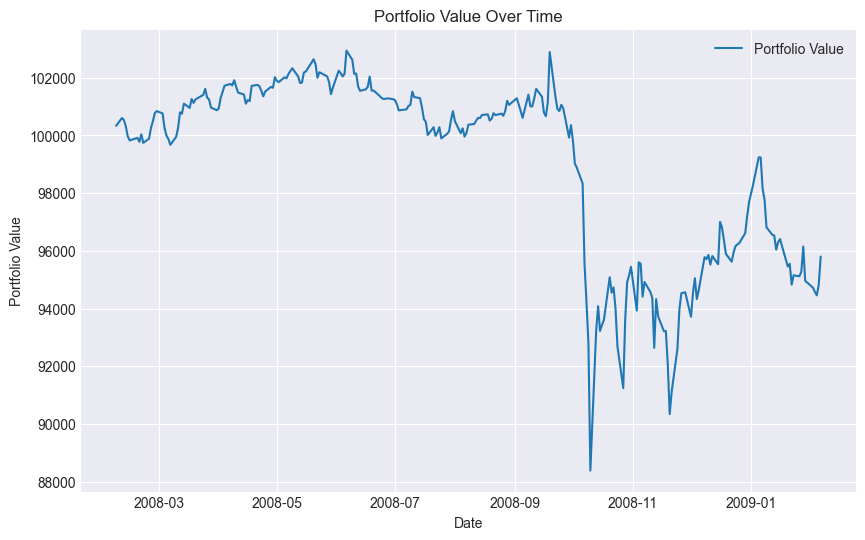

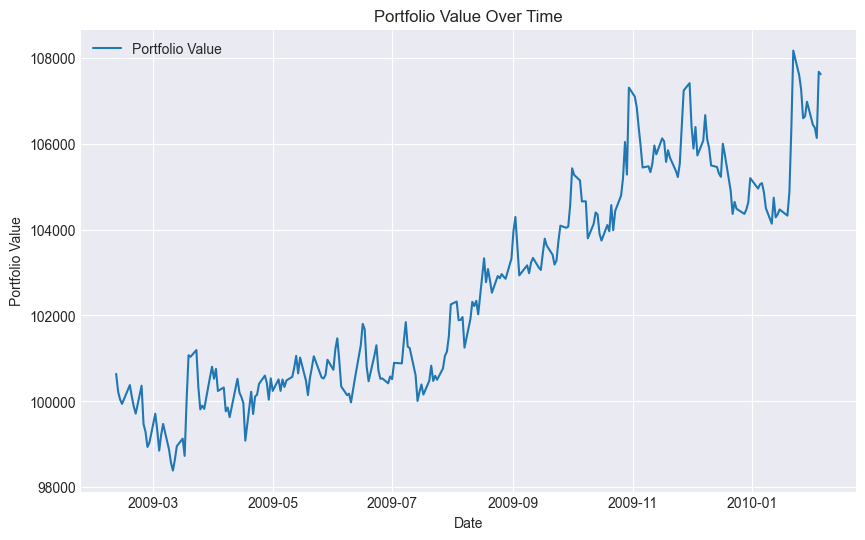

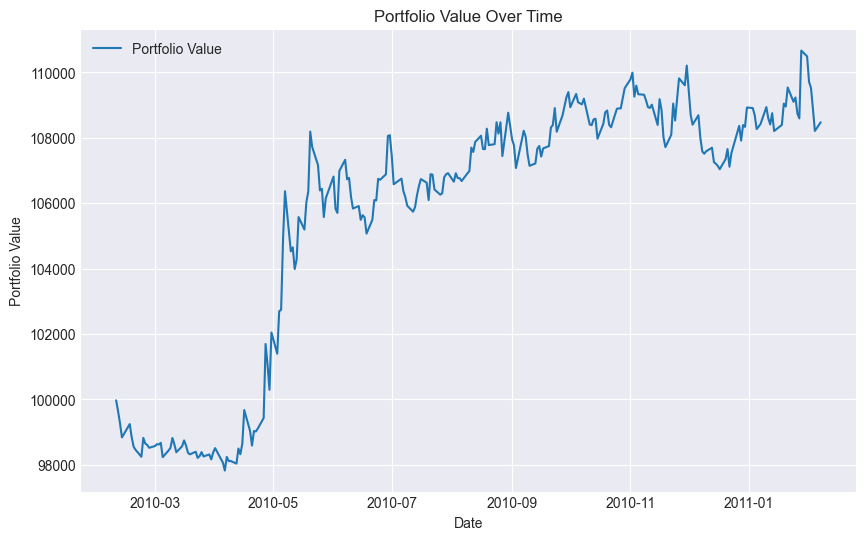

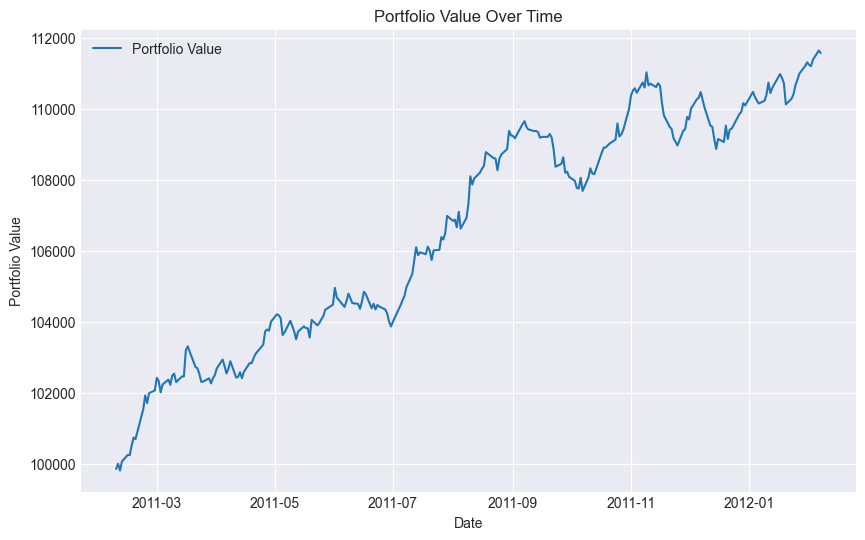

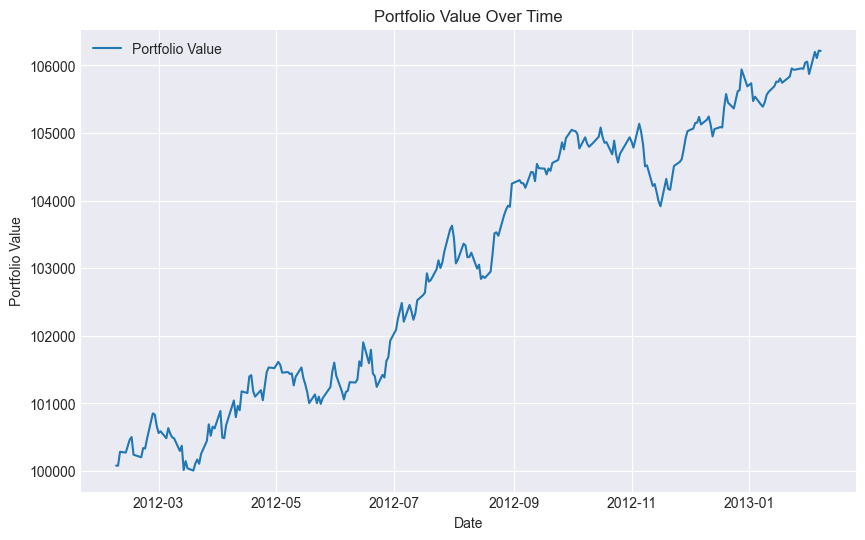

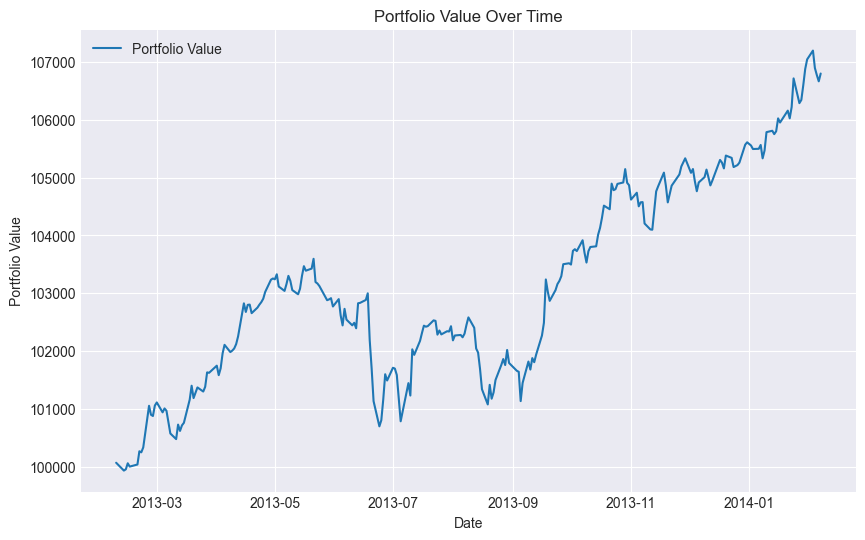

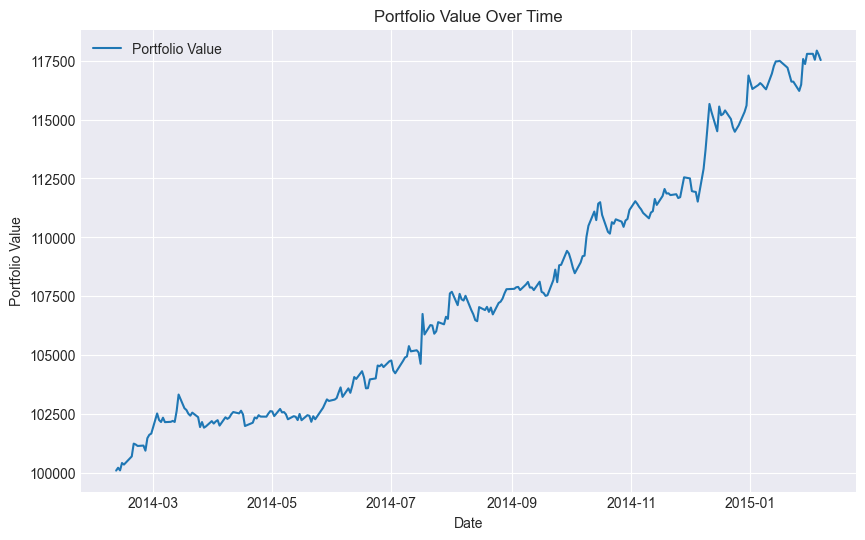

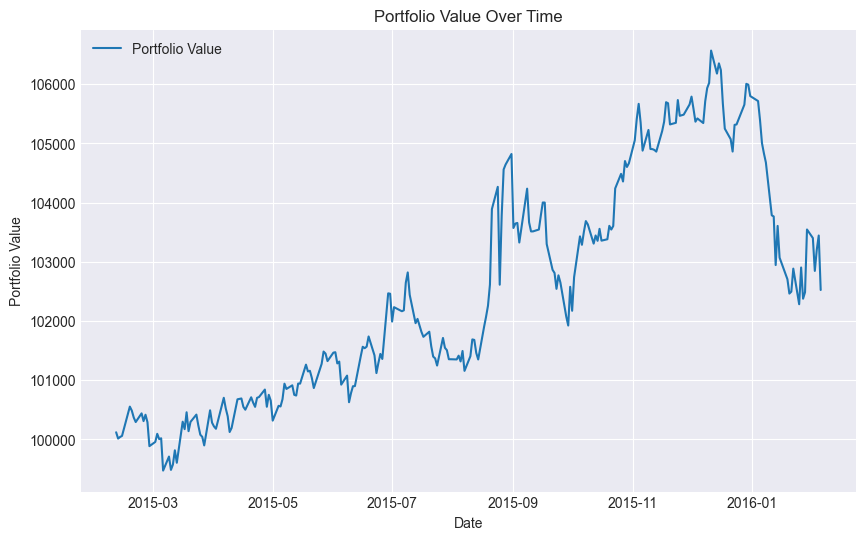

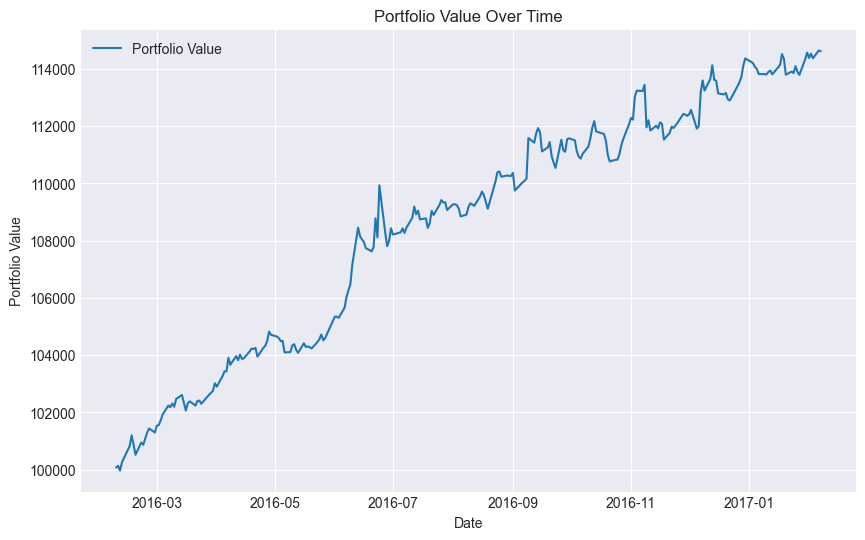

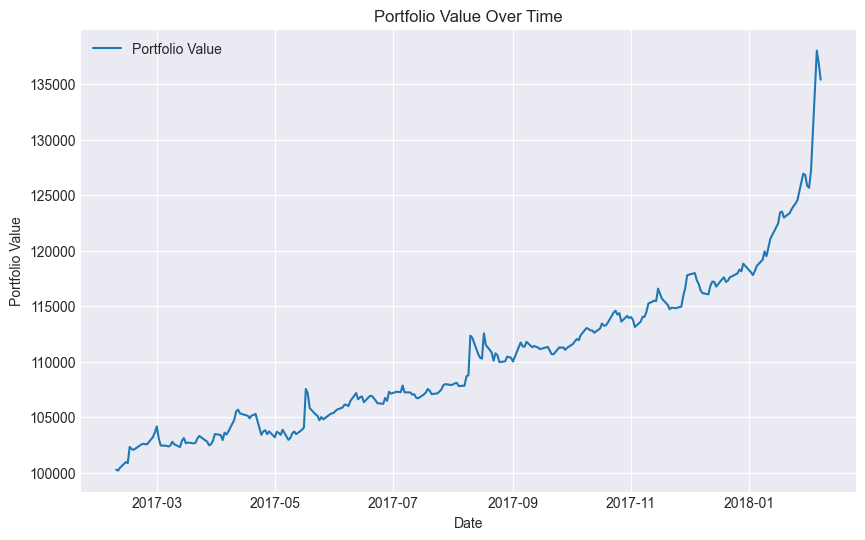

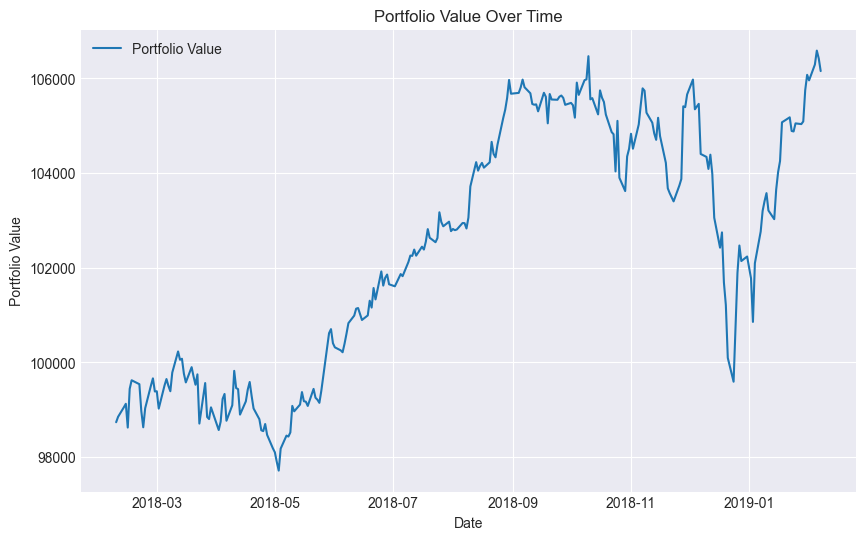

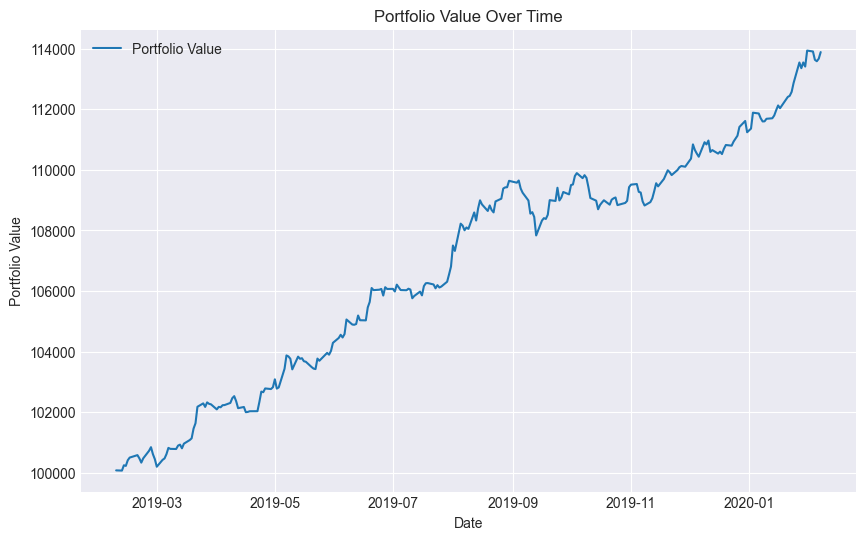

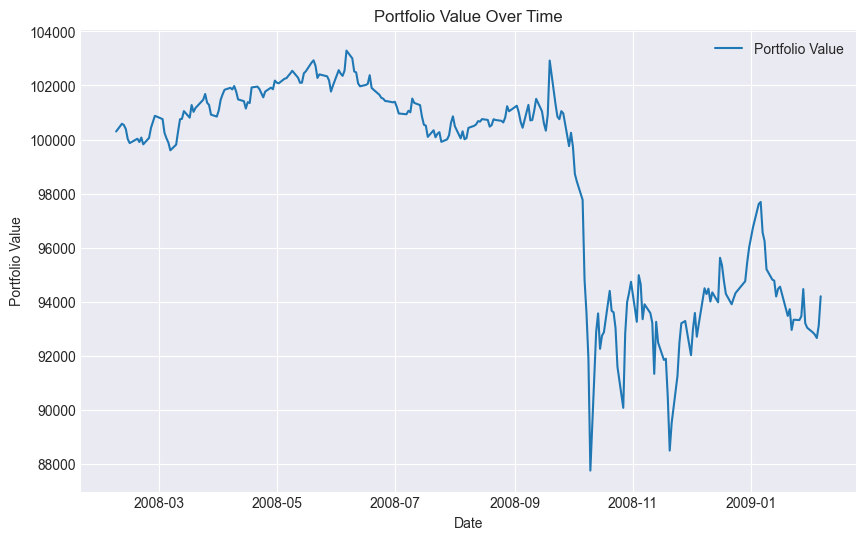

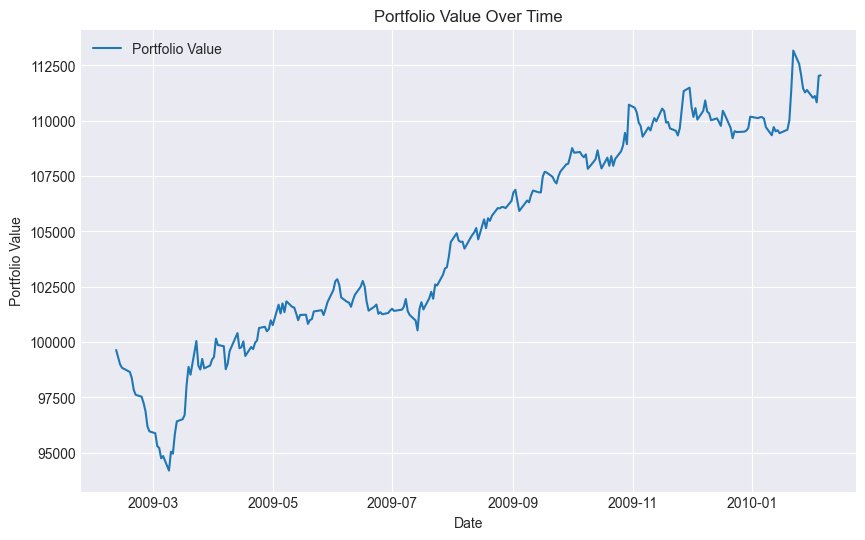

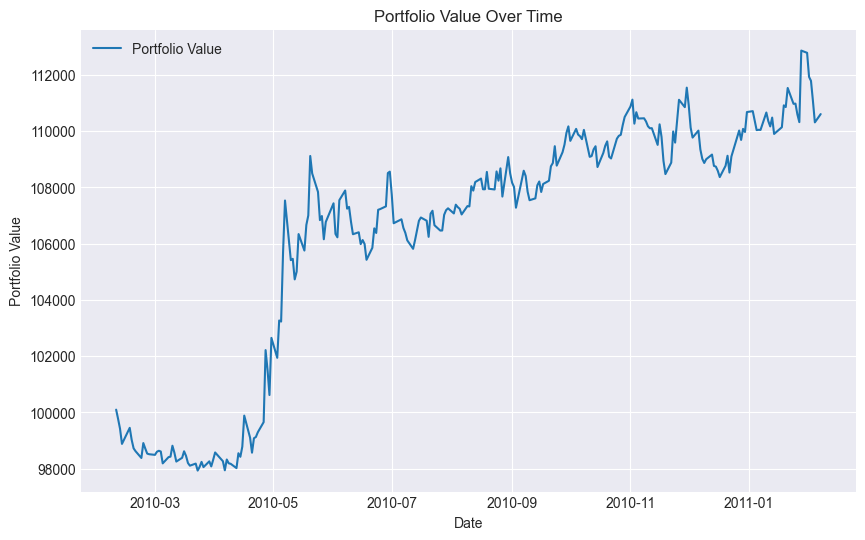

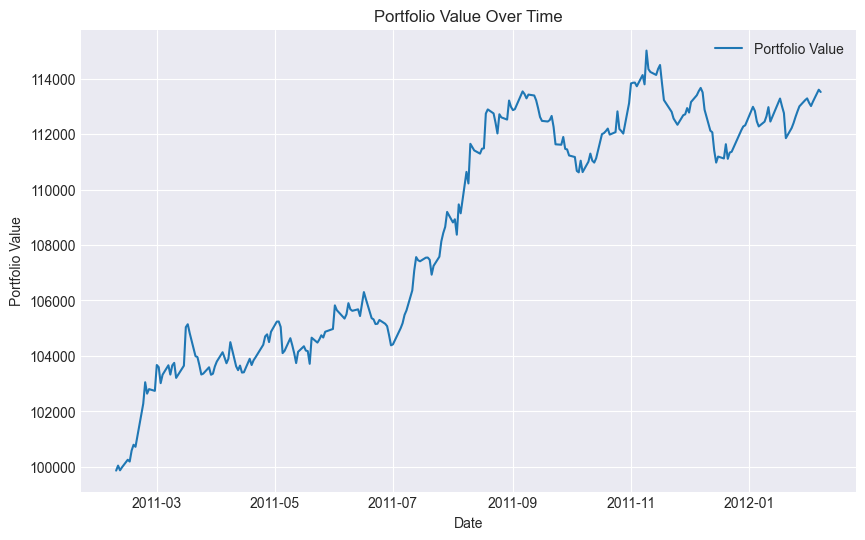

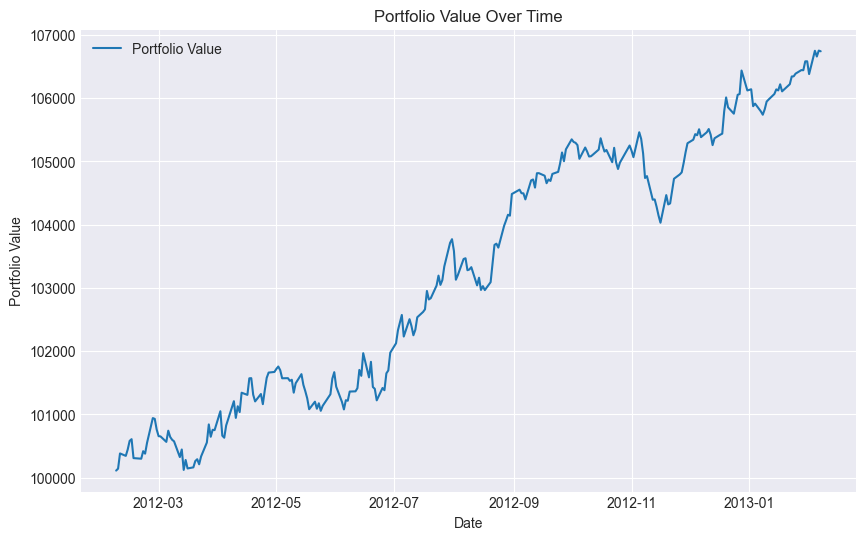

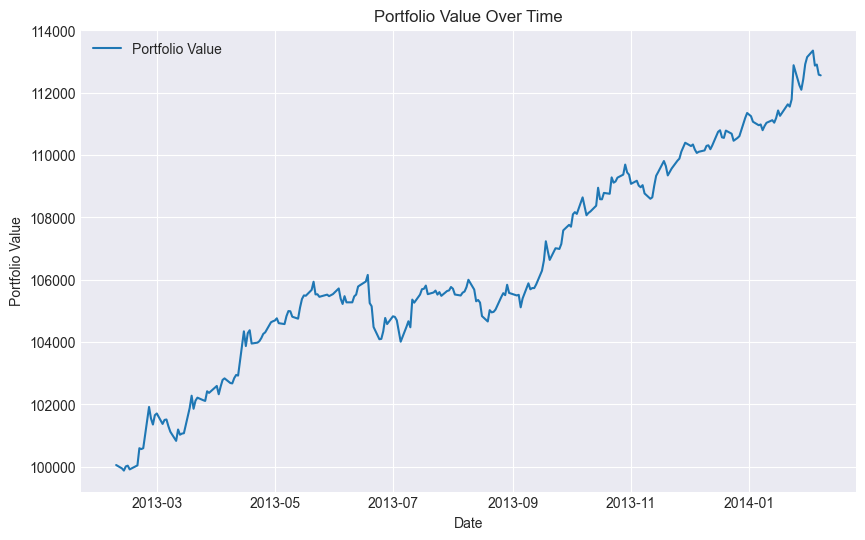

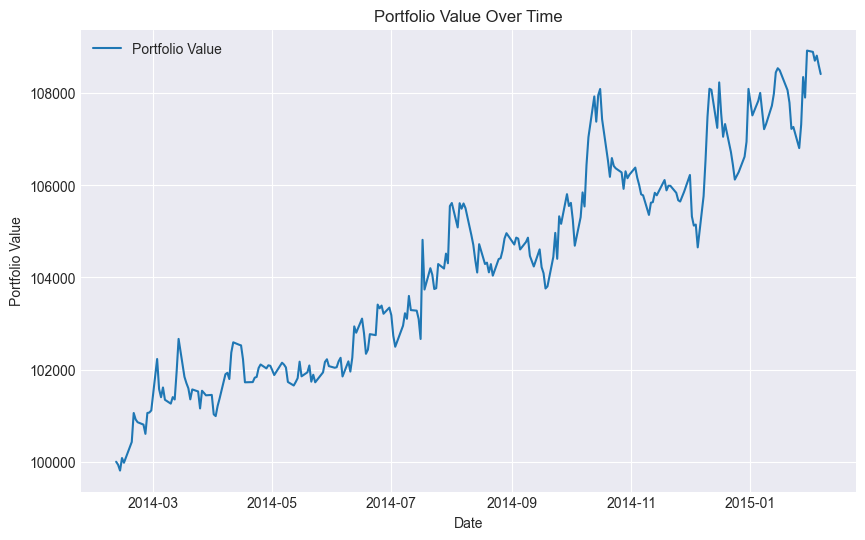

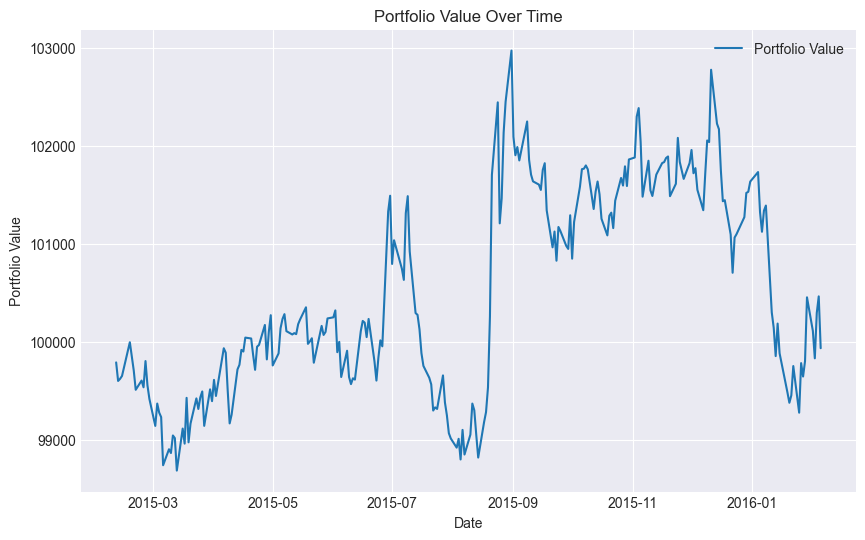

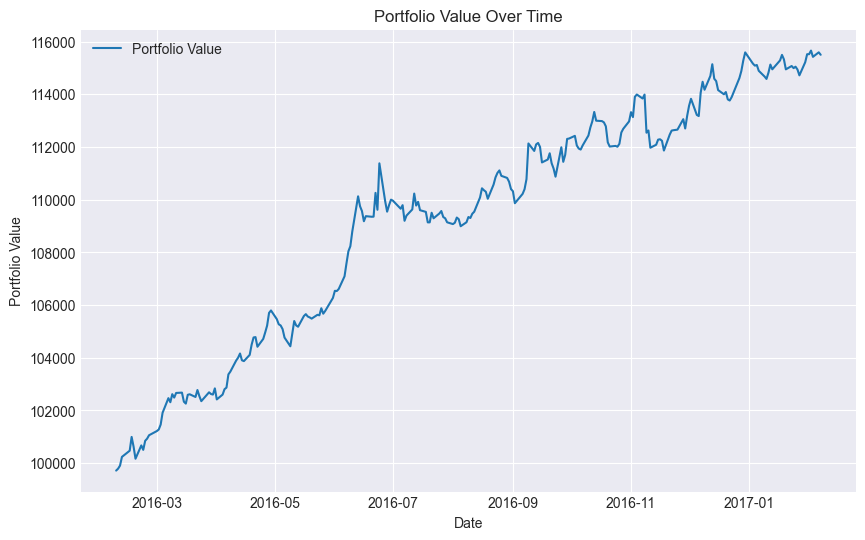

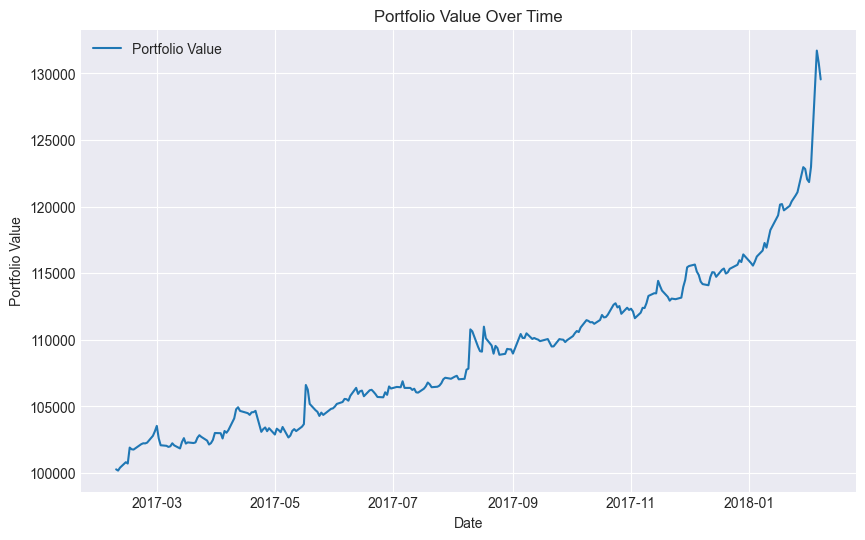

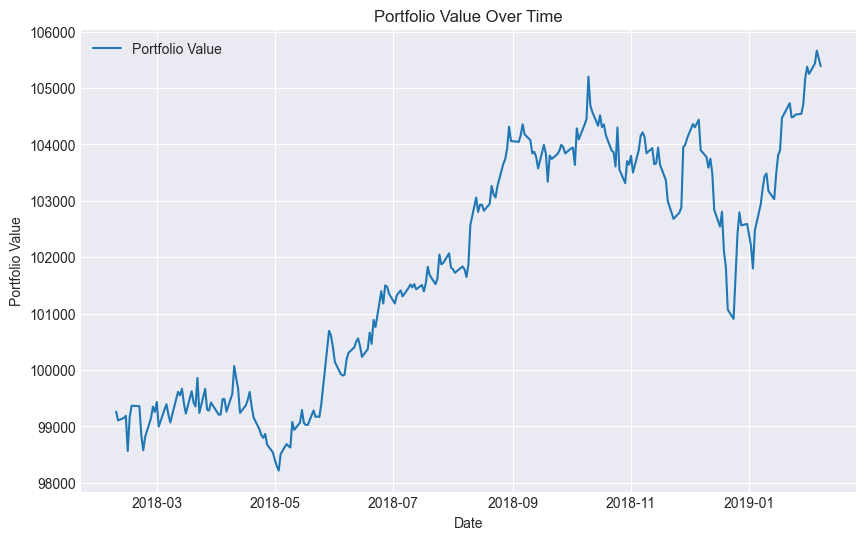

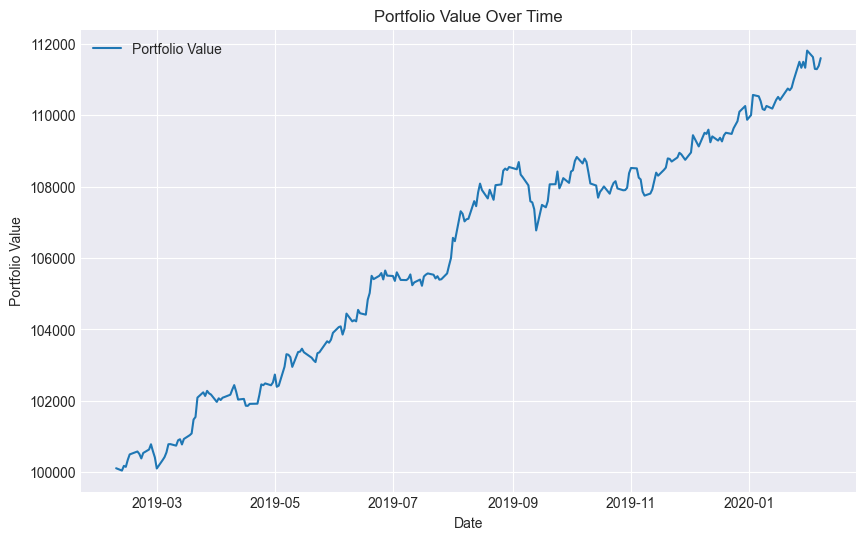

Mean-Variance Optimization Results: [{'train_period': (Timestamp('2006-02-06 00:00:00'), Timestamp('2008-02-06 00:00:00')), 'test_period': (Timestamp('2008-02-07 00:00:00'), Timestamp('2009-02-07 00:00:00')), 'metrics': {'Sharpe Ratio': -0.32376981320570203, 'Sortino Ratio': -0.40752479198782293, 'Max Drawdown': 0.14143123508100058}}, {'train_period': (Timestamp('2007-02-06 00:00:00'), Timestamp('2009-02-06 00:00:00')), 'test_period': (Timestamp('2009-02-07 00:00:00'), Timestamp('2010-02-07 00:00:00')), 'metrics': {'Sharpe Ratio': 0.9549595547791575, 'Sortino Ratio': 1.9847917444649568, 'Max Drawdown': 0.03048241673406757}}, {'train_period': (Timestamp('2008-02-06 00:00:00'), Timestamp('2010-02-06 00:00:00')), 'test_period': (Timestamp('2010-02-07 00:00:00'), Timestamp('2011-02-07 00:00:00')), 'metrics': {'Sharpe Ratio': 1.0309641390056996, 'Sortino Ratio': 2.035791839910763, 'Max Drawdown': 0.02882810311543834}}, {'train_period': (Timestamp('2009-02-06 00:00:00'), Timestamp('2011-02-0

In [9]:
# Define tickers and data parameters
tickers = ['VTI', 'AGG', 'DBC','^VIX']
data = get_data(tickers, '2006-01-01', '2021-01-04')
# Rolling validation with LSTM-based optimization (with periodic rebalancing)
lstm_results,lstm_values = generalized_rolling_validation(data, train_and_rebalance_portfolio)
print("LSTM Results:", lstm_results)
print("Final Portfolio Values:", lstm_values)
# Rolling validation with mean-variance optimization
mvo_results,mvo_values= generalized_rolling_validation(data, mean_variance_optimized_strategy)
# Rolling validation with maximum diversification optimization
md_results,md_values = generalized_rolling_validation(data, maximum_diversification)
print("Mean-Variance Optimization Results:", mvo_results)
print("Final Portfolio Values:", mvo_values)    


In [10]:
diff = [a - b for a, b in zip(lstm_values, mvo_values)]
print(diff)
print("Mean of the difference between LSTM and MVO:", np.mean(diff))
#average profit/average loss, a = final portfolio value for lstm, b = final value for mvo, starting cash = 100000
diff = [a - b for a, b in zip(lstm_values, md_values)]
print(diff)
print("Mean of the difference between LSTM and MD:", np.mean(diff))

# Calculate the average profit/average loss ratio
average_profit = np.mean([a - 100000 for a in lstm_values if a > 100000])
average_loss = 1
average_loss_calc = np.mean([100000 - b for b in mvo_values if b < 100000])
if average_loss_calc != 0:
    average_loss = average_loss_calc
profit_loss_ratio = average_profit / average_loss
print("LSTM profit/loss ratio:", profit_loss_ratio)

average_profit = np.mean([b - 100000 for b in mvo_values if b > 100000])
average_loss = 1
average_loss_calc = np.mean([100000 - b for b in mvo_values if b < 100000])
if average_loss_calc != 0:
    average_loss = average_loss_calc
profit_loss_ratio = average_profit / average_loss
print("MVO profit/loss ratio:", profit_loss_ratio)

average_profit = np.mean([b - 100000 for b in md_values if b > 100000])
average_loss = 1
average_loss_calc = np.mean([100000 - b for b in md_values if b < 100000])
if average_loss_calc != 0:
    average_loss = average_loss_calc
profit_loss_ratio = average_profit / average_loss
print("MD profit/loss ratio:", profit_loss_ratio)


[-672.8938623423164, 2675.784557784442, 11401.689085720747, 2631.3067145304667, 2976.079345020844, 4211.599270358187, -666.5396317050181, -371.198089423051, -6503.51748680009, -4169.351125392481, -2152.8969824374653, -1160.6839061844512]
Mean of the difference between LSTM and MVO: 683.2814907608177
[928.429422418616, -1745.5946540349833, 9271.78714866632, 691.6106158574985, 2451.014821912264, -1545.1633932432887, 8452.458225364695, 2220.3662100121583, -7387.476068345961, 1679.1260954694153, -1383.9995004816592, 1125.639162802312]
Mean of the difference between LSTM and MD: 1229.8498405331156
LSTM profit/loss ratio: 3.025975275657239
MVO profit/loss ratio: 2.8337465646713906
MD profit/loss ratio: 4.293310799263041
